<a href="https://colab.research.google.com/github/mobarakol/PitVQA_Annotations/blob/main/Annotations_Creation/label_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part1: generate images: This part is to transfer video to images





In [ ]:
# global imports
import cv2
import numpy as np
import os

# strong typing
from pathlib import Path
from typing import List
from time import time
from google.colab import drive
'''
Before run this code, your folder system should look like this:
project-name/
├── videos/
│   ├── video_01.mp4
│   └── video_02.mp4
│   └── ...
│   └── video_25.mp4
├── images/
├── video_to_images.py
note: 'images' is an empty folder before running this code.
'''

def main():
    """required variables are {pt_videos} and {pt_images}"""
    # Mount Google Drive
    drive.mount('/content/drive')

    # Update paths to point to Google Drive
    pt_videos = Path("/content/drive/My Drive/annotations/videos")# Replace your own address here
    pt_images = Path("/content/drive/My Drive/annotations/images")# Replace your own address here

    st = time()
    convert_videos_to_images(pt_videos=pt_videos, pt_images=pt_images)
    et = time()
    print(f'time used: {et-st}')

def convert_videos_to_images(pt_videos: Path, pt_images: Path):
    """convert all videos from {pt_videos} to images saved to {pt_images}"""
    create_directory(pt=pt_images)

    ls_videos: List[str] = os.listdir(pt_videos)
    ls_videos.sort()

    for str_video in ls_videos:
        pt_video: Path = pt_videos.joinpath(str_video)
        pt_image: Path = pt_images.joinpath(str_video.split(".")[0])

        create_directory(pt=pt_image)
        convert_video_to_image(pt_video=pt_video, pt_image=pt_image)
        print(f'{str_video} finished.')

def convert_video_to_image(pt_video: Path, pt_image: Path):
    """convert a single video from {pt_video} to images saved to {pt_image}"""
    video_capture = cv2.VideoCapture(str(pt_video))
    int_frames_per_second: int = np.ceil(video_capture.get(cv2.CAP_PROP_FPS))  # ceiling function to ensure integer

    int_frame: int = 0
    while video_capture.isOpened():
        bool_success, np_frame_matrix = video_capture.read()
        if bool_success:
            if int_frame % int_frames_per_second == 0:
                pt_image_frame: Path = pt_image.joinpath(f"{int(int_frame / int_frames_per_second):05}.png")
                cv2.imwrite(str(pt_image_frame), np_frame_matrix)
                print("written")
        else:
            break
        int_frame += 1

    video_capture.release()

    print(f"{pt_video} successfully converted to {int_frame} images.")

def create_directory(pt: Path):
    """create a directory for a given {path} if it does not already exist"""
    if not os.path.exists(pt):
        os.mkdir(pt)

main()



Part2: Image process: This part is to process the images

In [ ]:
import os
import glob
from PIL import Image, ImageOps
from pathlib import Path
from google.colab import drive

'''
Before run this code, your folder system should look like this:
project-name/
├── images/
│   ├── video_01/
│   └── video_02/
│   └── ...
│   └── video_25/
├── preprocessed_images/
├── preprocess_images.py
note: 'preprocessed_images' is an empty folder before running this code.
'''

if __name__ == '__main__':
    # Mount Google Drive
    drive.mount('/content/drive')

    # Update paths to point to Google Drive
    base_path = Path("/content/drive/My Drive/annotations") # Repalce your own address here
    images_path = base_path / 'images'
    output_path = base_path / 'preprocessed_images'

    # Specify video sequences
    video_sequence = [f"video_{i:03}" for i in [18, 19, 33, 35]] # Modify this palce according to your own video index

    for seq in video_sequence:
        folder_path = images_path / seq
        images = folder_path.glob('*.png')

        # Create a new folder (e.g., video_01/) in the 'preprocessed_images' folder
        new_folder = output_path / seq
        new_folder.mkdir(parents=True, exist_ok=True)

        for img in images:
            image = Image.open(img)

            # Process images
            crop_box = (295, 50, 935, 690)
            cropped_image = image.crop(crop_box)  # Crop images
            resized_image = cropped_image.resize((224, 224), Image.BICUBIC)  # Resize images

            # Save processed images
            save_path = new_folder / img.name
            resized_image.save(save_path)
        print(seq + ' done.')


video_018 done.
video_019 done.
video_033 done.
video_035 done.


Part3: Text files generation: This part is to create the empty QA text files for each video

In [ ]:
import os
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# path to images folder
images_folder = Path("/content/drive/My Drive/annotations/images")
# path to QA folder
qa_folder = Path("/content/drive/My Drive/annotations/QA")

# create QA folder if needed
qa_folder.mkdir(parents=True, exist_ok=True)

# go through images folder
for folder in images_folder.iterdir():
    if folder.is_dir():
        folder_path = folder  # images/video_01

        # create counterpart sub-folder in QA folder
        qa_subfolder_path = qa_folder / folder.name  # QA/video_01
        qa_subfolder_path.mkdir(parents=True, exist_ok=True)

        # create txt file for each image
        for file in folder.iterdir():
            if file.suffix == '.png':
                txt_filename = file.stem + '.txt'
                txt_filepath = qa_subfolder_path / txt_filename
                txt_filepath.touch()


Part4：Instruments file generation: To finish the labeling work, instruments files and video files is compulsory. If you have these two kinds of files, please go to Part 6. Otherwise, please run the code from part4 and part5 first to generate intruments filess and steps files with the annotation file like in the image below:


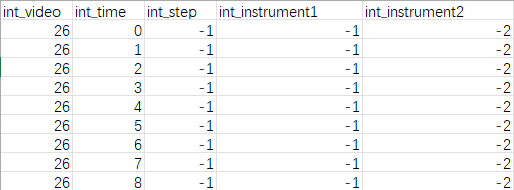


To run this part, you also need the map_instruments.csv file which can be found tin the meta_data folder of this repository


In [ ]:
import pandas as pd
from pathlib import Path

def generate_instruments_csv_batch():
    # Define file paths, replace your own address here
    input_folder = Path("/content/drive/My Drive/annotations/annotation_files")
    mapping_file = Path("/content/drive/My Drive/map_instruments.csv")
    output_folder = Path("/content/drive/My Drive/annotations/instruments")

    # Ensure output folder exists
    output_folder.mkdir(parents=True, exist_ok=True)

    # Load mapping file
    try:
        mapping_df = pd.read_csv(mapping_file, encoding='utf-8')
    except UnicodeDecodeError:
        mapping_df = pd.read_csv(mapping_file, encoding='ISO-8859-1')

    # Create mapping dictionary
    instrument_mapping = dict(zip(mapping_df['int_instrument'], mapping_df['str_instrument']))

    # Process each annotations file in the input folder
    for annotations_file in input_folder.glob("annotations_*.csv"):
        try:
            # Load annotations file
            annotations_df = pd.read_csv(annotations_file, encoding='utf-8')
        except UnicodeDecodeError:
            annotations_df = pd.read_csv(annotations_file, encoding='ISO-8859-1')

        # Create a copy of the annotations data to process
        processed_df = annotations_df.copy()

        # Map int_instrument1 and int_instrument2 to their string representations
        processed_df['str_instrument1'] = processed_df['int_instrument1'].map(instrument_mapping)
        processed_df['str_instrument2'] = processed_df['int_instrument2'].map(instrument_mapping)

        # Add empty columns for pos_instrument1 and pos_instrument2
        processed_df['pos_instrument1'] = ''
        processed_df['pos_instrument2'] = ''

        # Rearrange the column order
        output_columns = [
            'int_video',
            'int_time',
            'str_instrument1',
            'str_instrument2',
            'int_instrument1',
            'int_instrument2',
            'pos_instrument1',
            'pos_instrument2'
        ]

        # Modify output file name
        output_file_name = annotations_file.name.replace("annotations_", "instruments_")
        output_file = output_folder / output_file_name

        # Save the generated CSV file
        processed_df[output_columns].to_csv(output_file, index=False)

        print(f"File successfully generated: {output_file}")

if __name__ == "__main__":
    generate_instruments_csv_batch()


Part5：Steps file generation: To finish the labeling work, instruments files and video files is compulsory. If you have these two kinds of files, please go to Part 6. Otherwise, please run the code from part4 and part5 first to generate intruments filess and steps files with the annotation file.
To run this part, you also need the map_steps.csv file which can be found tin the meta_data folder of this repository

In [ ]:
import pandas as pd
from pathlib import Path

def generate_step_csv_batch():
    # Define file paths
    input_folder = Path("/content/drive/My Drive/annotations/annotation_files")
    steps_mapping_file = Path("/content/drive/My Drive/map_steps.csv")
    output_folder = Path("/content/drive/My Drive/steps")

    # Ensure output folder exists
    output_folder.mkdir(parents=True, exist_ok=True)

    # Load mapping file
    steps_mapping_df = pd.read_csv(steps_mapping_file)

    # Create mapping dictionary
    step_mapping = dict(zip(steps_mapping_df['int_step'], steps_mapping_df['str_step']))

    # Process each annotations file in the input folder
    for annotations_file in input_folder.glob("annotations_*.csv"):
        # Load annotations file
        annotations_df = pd.read_csv(annotations_file)

        # Initialize result list
        results = []

        # Get initial row information
        previous_step = None
        start_time = None
        int_video = annotations_df['int_video'].iloc[0]  # Assume all rows have the same int_video

        # Iterate through annotations_df
        for index, row in annotations_df.iterrows():
            current_step = row['int_step']
            current_time = row['int_time']

            # Detect step change
            if previous_step is None:
                previous_step = current_step
                start_time = current_time
            elif current_step != previous_step:
                # Save change information
                results.append({
                    'int_video': int_video,
                    'int_time': start_time,
                    'str_step': step_mapping.get(previous_step, 'Unknown'),
                    'int_step': previous_step
                })
                # Update start time and current step
                previous_step = current_step
                start_time = current_time

        # Add the last step's information
        if previous_step is not None:
            results.append({
                'int_video': int_video,
                'int_time': start_time,
                'str_step': step_mapping.get(previous_step, 'Unknown'),
                'int_step': previous_step
            })

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)

        # Modify output file name
        output_file_name = annotations_file.name.replace("annotations_", "steps_")
        output_file = output_folder / output_file_name

        # Save to CSV file
        results_df.to_csv(output_file, index=False)

        print(f"File successfully generated: {output_file}")

if __name__ == "__main__":
    generate_step_csv_batch()


Part6: Labeling: This code is to label the images with QA pairs. In this part the empty QA txt files will be filled with QA pairs.

In [ ]:

import os
import pandas as pd

# try:
#     from utils import (step_phase_mapping, next_step_mapping, next_phase_mapping,
#                        step_operation_mapping, number_location_mapping)
# except ImportError:
#     import sys
#     sys.path.append('D:\\MSc Dataset\\Annotaion18193335\\utils.py')
#     from utils import (step_phase_mapping, next_step_mapping, next_phase_mapping,
#                        step_operation_mapping, number_location_mapping)

count_dict = {}
frames = 0
questions = 0

def step_phase_mapping(step_name):
    if step_name in ['nasal corridor creation', 'anterior sphenoidotomy', 'septum displacement', 'sphenoid sinus clearance']:
        return 'nasal sphenoid'
    elif step_name in ['sellotomy', 'durotomy', 'tumour excision']:
        return 'sellar'
    elif step_name in ['haemostasis', 'synthetic graft placement', 'fat graft placement',
                       'gasket seal construct', 'dural sealant', 'nasal packing', 'debris clearance']:
        return 'closure'
    elif step_name in ['operation not started', 'operation ended', 'out of patient']:
        return 'UNDEFINED PHASE: the step is not 1 of 14 steps'
    else:
        return 'Unknown phase'

def next_step_mapping(current_step):
    steps = [
        'nasal corridor creation', 'anterior sphenoidotomy', 'septum displacement', 'sphenoid sinus clearance',
        'sellotomy', 'durotomy', 'tumour excision', 'haemostasis', 'synthetic graft placement',
        'fat graft placement', 'gasket seal construct', 'dural sealant', 'nasal packing', 'debris clearance'
    ]
    if current_step in steps:
        idx = steps.index(current_step)
        return steps[idx + 1] if idx + 1 < len(steps) else 'end of step'
    elif current_step == 'operation not started':
        return 'Current step is operation not started'
    elif current_step == 'operation ended':
        return 'Current step is operation ended'
    elif current_step == 'out of patient':
        return 'Current step is out of patient'
    else:
        return 'Unknown next step'

def next_phase_mapping(current_phase):
    if current_phase == 'nasal sphenoid':
        return 'sellar'
    elif current_phase == 'sellar':
        return 'closure'
    elif current_phase == 'closure':
        return 'end of phase'
    elif current_phase == 'UNDEFINED PHASE: the step is not 1 of 14 steps':
        return 'Invalid current phase'
    else:
        return 'Unknown phase'

def step_operation_mapping(step_name):
    operations = {
        'nasal corridor creation': 'The middle and superior turbinates are laterally displaced',
        'anterior sphenoidotomy': 'The sphenoid ostium is identified and opened',
        'septum displacement': 'The septum is displaced until the opposite ostium is seen',
        'sphenoid sinus clearance': 'The sphenoid sinus is opened, with removal of sphenoid septations to expose the face of the sella and mucosa',
        'sellotomy': 'The sella is identified, confirmed and carefully opened',
        'durotomy': 'A cruciate durotomy is performed',
        'tumour excision': 'The tumour is seen and removed in a piecemeal fashion',
        'haemostasis': 'Haemostasis is achieved with a surgiflo, a bipolar cautery, and a spongostan placement',
        'synthetic graft placement': 'spongostan, tachosil and duragen placement',
        'fat graft placement': 'A fat graft is placed over the defect',
        'gasket seal construct': 'A MedPor implant and a fascia lata graft are placed',
        'dural sealant': 'Evicel and Adherus dural sealant are applied',
        'nasal packing': 'The nasal cavity is packed with Bismuth soaked ribbon gauze',
        'debris clearance': 'Debris is cleared from the nasal cavity and choana',
        'operation not started': 'UNDEFINED OPERATION',
        'operation ended': 'UNDEFINED OPERATION',
        'out of patient': 'UNDEFINED OPERATION',
    }
    return operations.get(step_name, 'Unknown operation')

def number_location_mapping(location_code):
    locations = {
        '1.0': 'top-left',
        '2.0': 'top-right',
        '3.0': 'centre',
        '4.0': 'bottom-left',
        '5.0': 'bottom-right',
    }
    return locations.get(location_code, 'Unknown location')


def prepare_what_phase_qa(step_name):
    question = 'What is the surgical phase shown in the image?'
    answer = 'The surgical phase shown in the image is ' + step_phase_mapping(step_name) + '.'
    qa = question + '|' + answer
    if answer not in count_dict.keys():
        count_dict[answer] = 1
    else:
        count_dict[answer] += 1
    return qa, answer


def prepare_what_step_qa(step_name):
    question = 'What is the surgical step shown in this frame?'
    answer = 'The surgical step shown in the image is ' + step_name + '.'
    qa = question + '|' + answer
    if answer not in count_dict.keys():
        count_dict[answer] = 1
    else:
        count_dict[answer] += 1
    return qa


def prepare_next_phase_qa(current_phase):
    question = 'What is the next surgical phase?'
    answer = 'The next surgical phase is ' + next_phase_mapping(current_phase)+ '.'
    qa = question + '|' + answer
    if answer not in count_dict.keys():
        count_dict[answer] = 1
    else:
        count_dict[answer] += 1
    return qa


def prepare_next_step_qa(current_step):
    question = 'What is the next surgical step?'
    answer = 'The next surgical step is ' + next_step_mapping(current_step)+ '.'
    qa = question + '|' + answer
    if answer not in count_dict.keys():
        count_dict[answer] = 1
    else:
        count_dict[answer] += 1
    return qa


def prepare_how_many_tool_qa(num_of_tool):
    question = 'How many instruments are present in the image?'
    answer = f'{num_of_tool} instruments are present in the image.'
    if num_of_tool == 0:
        answer = 'No instrument is present in the image.'
    elif num_of_tool == 1:
        answer = 'One instrument is present in the image.'
    elif num_of_tool == 2:
        answer = 'Two instruments are present in the image.'
    qa = question + '|' + answer
    if answer not in count_dict.keys():
        count_dict[answer] = 1
    else:
        count_dict[answer] += 1
    return qa


def prepare_what_operation_qa(step_name):
    question = 'What is the surgical operation performed in the image?'
    answer = 'The surgical operation performed in the image is: "' + step_operation_mapping(step_name) +'."'
    qa = question + '|' + answer
    if answer not in count_dict.keys():
        count_dict[answer] = 1
    else:
        count_dict[answer] += 1
    return qa, answer


def prepare_what_tool_qa_one(row_content):
    # What instrument is used in the bottom-mid of the image? | 1 of 18 instruments
    qa = 0
    if pd.notna(row_content['pos_instrument1']):
        if str(row_content['pos_instrument1']) == '3.0':
            question = 'What instrument is used at the centre of the image?'
            answer = f"The instrument present at the center of the image is {row_content['str_instrument1']}."
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
        else:
            position = number_location_mapping(str(row_content['pos_instrument1']))
            question = f'What instrument is used in the {position} of the image?'
            answer =  f"The instrument present in the {position} of the image is {row_content['str_instrument1']}."
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
    elif pd.notna(row_content['pos_instrument2']):
        if str(row_content['pos_instrument2']) == '3.0':
            question = 'What instrument is used at the centre of the image?'
            answer = f"The instrument present at the center of the image is {row_content['str_instrument2']}."
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
        else:
            position = number_location_mapping(str(row_content['pos_instrument2']))
            question = f'What instrument is used in the {position} of the image?'
            answer = f"The instrument present in the {position} of the image is {row_content['str_instrument2']}."
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
    return qa


def prepare_tool_operation_qa(row_content, operation):
    # What surgical activity is performing by the instrument kerrisons? | 1 of 14 operations
    qa = 0
    if pd.notna(row_content['pos_instrument1']):
        tool = row_content['str_instrument1']
        question = f'What surgical activity is performing by the instrument {tool}?'
        answer = operation+ '.'
        qa = question + '|' + answer
        if answer not in count_dict.keys():
            count_dict[answer] = 1
        else:
            count_dict[answer] += 1
    elif pd.notna(row_content['pos_instrument2']):
        tool = row_content['str_instrument2']
        question = f'What surgical activity is performing by the instrument {tool}?'
        answer = operation+ '.'
        qa = question + '|' + answer
        if answer not in count_dict.keys():
            count_dict[answer] = 1
        else:
            count_dict[answer] += 1
    return qa


def prepare_where_tool_qa(row_content):
    # Where is the surgical instrument kerrisons tip located in the image? | 1 of 5 locations
    qa = 0
    if pd.notna(row_content['pos_instrument1']):
        tool = row_content['str_instrument1']
        question = f'Where is the surgical instrument {tool} tip located in the image?'
        answer = f"The surgical instrument {tool} tip is located at {number_location_mapping(str(row_content['pos_instrument1']))}."
        qa = question + '|' + answer
        if answer not in count_dict.keys():
            count_dict[answer] = 1
        else:
            count_dict[answer] += 1
    elif pd.notna(row_content['pos_instrument2']):
        tool = row_content['str_instrument2']
        question = f'Where is the surgical instrument {tool} tip located in the image?'
        answer = f"The surgical instrument {tool} tip is located at {number_location_mapping(str(row_content['pos_instrument2']))}."
        qa = question + '|' + answer
        if answer not in count_dict.keys():
            count_dict[answer] = 1
        else:
            count_dict[answer] += 1
    return qa


def prepare_what_tool_qa_two(row_content, col_num):
    # What instrument is used in the bottom-mid of the image? | 1 of 18 instruments
    qa = 0
    if col_num == 1:  # tool 1
        if pd.notna(row_content['pos_instrument1']):
            if str(row_content['pos_instrument1']) == '3.0':
                question = 'What instrument is used at the centre of the image?'
                answer = f"The instrument present at the center of the image is {row_content['str_instrument1']}."
                qa = question + '|' + answer
                if answer not in count_dict.keys():
                    count_dict[answer] = 1
                else:
                    count_dict[answer] += 1
            else:
                position = number_location_mapping(str(row_content['pos_instrument1']))
                question = f'What instrument is used in the {position} of the image?'
                answer = f"The instrument present in the {position} of the image is {row_content['str_instrument1']}."
                qa = question + '|' + answer
                if answer not in count_dict.keys():
                    count_dict[answer] = 1
                else:
                    count_dict[answer] += 1
    elif col_num == 2:
        if pd.notna(row_content['pos_instrument2']):
            if str(row_content['pos_instrument2']) == '3.0':
                question = 'What instrument is used at the centre of the image?'
                answer = f"The instrument present at the center of the image is {row_content['str_instrument2']}."
                qa = question + '|' + answer
                if answer not in count_dict.keys():
                    count_dict[answer] = 1
                else:
                    count_dict[answer] += 1
            else:
                position = number_location_mapping(str(row_content['pos_instrument2']))
                question = f'What instrument is used in the {position} of the image?'
                answer = f"The instrument present in the {position} of the image is {row_content['str_instrument2']}."
                qa = question + '|' + answer
                if answer not in count_dict.keys():
                    count_dict[answer] = 1
                else:
                    count_dict[answer] += 1
    return qa


def prepare_tool_operation_qa_two(row_content, operation, col_num):
    # What surgical activity is performing by the instrument kerrisons? | 1 of 14 operations
    qa = 0
    if col_num == 1:
        if pd.notna(row_content['pos_instrument1']):
            tool = row_content['str_instrument1']
            question = f'What surgical activity is performing by the instrument {tool}?'
            answer = operation+'.'
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
    elif col_num == 2:
        if pd.notna(row_content['pos_instrument2']):
            tool = row_content['str_instrument2']
            question = f'What surgical activity is performing by the instrument {tool}?'
            answer = operation+'.'
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
    return qa


def prepare_where_tool_qa_two(row_content, col_num):
    # Where is the surgical instrument kerrisons tip located in the image? | 1 of 5 locations
    qa = 0
    if col_num == 1:
        if pd.notna(row_content['pos_instrument1']):
            tool = row_content['str_instrument1']
            question = f'Where is the surgical instrument {tool} tip located in the image?'
            answer =  f"The surgical instrument {tool} tip is located at {number_location_mapping(str(row_content['pos_instrument1']))}."
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
    elif col_num == 2:
        if pd.notna(row_content['pos_instrument2']):
            tool = row_content['str_instrument2']
            question = f'Where is the surgical instrument {tool} tip located in the image?'
            answer =  f"The surgical instrument {tool} tip is located at {number_location_mapping(str(row_content['pos_instrument2']))}."
            qa = question + '|' + answer
            if answer not in count_dict.keys():
                count_dict[answer] = 1
            else:
                count_dict[answer] += 1
    return qa


def get_num_of_tool(row_content):  # row_content is the content for that row
    if pd.isna(row_content['pos_instrument1']) and pd.isna(row_content['pos_instrument2']):
        number_of_tool = 0
    elif pd.notna(row_content['pos_instrument1']) and pd.notna(row_content['pos_instrument2']):
        number_of_tool = 2
    else:
        number_of_tool = 1
    return number_of_tool


def get_current_step_name(step_df, time_list, index):
    row_idx = 0
    for time in time_list:
        if index < time:
            row_idx = time_list.index(time)-1
            break
    step_name = step_df.iloc[row_idx]['str_step']
    return step_name


def write_file(video_folder, file_name, qa_list):
    file = os.path.join(video_folder, file_name)
    with open(file, 'w', encoding='utf-8') as f:
        for qa in qa_list:
            f.write(qa + '\n')


if __name__ == "__main__":

    tool_num = {}
    for i in [18]:
        print(f'processing file {i}')
        QA_folder = r'D:\MSc Dataset\Annotaion18193335\QA'
        video_num = 'video_' + f"{i:03d}"
        video_folder = os.path.join(QA_folder, video_num)

        instrument_folder = r'D:\MSc Dataset\Annotaion18193335\instruments'
        instrument_num = 'instruments_' + f"{i:03d}" + '.csv'
        instrument_file = os.path.join(instrument_folder, instrument_num)

        step_folder = r'D:\MSc Dataset\Annotaion18193335\steps'
        step_num = 'steps_' + f"{i:03d}" + '.csv'
        step_file = os.path.join(step_folder, step_num)

        # open instrument file
        instrument_df = pd.read_csv(instrument_file)
        # open step file
        step_df = pd.read_csv(step_file)
        int_time_list = list(step_df['int_time'])

        # go through video folder
        for idx, file_name in enumerate(os.listdir(video_folder)):  # 遍历video_01下的所有txt文件; 0, 00000.txt; 自动忽略第一行
            # instrument csv file
            instrument_row = instrument_df.iloc[idx]  # 第idx+1行
            num_of_tool = get_num_of_tool(instrument_row)

            if (instrument_row['str_instrument1'] == 'out_of_patient' or
                    instrument_row['str_instrument2'] == 'out_of_patient'):
                continue

            # step csv file
            step_name = get_current_step_name(step_df, int_time_list, idx).replace('\u3000', ' ').strip().lower()
            print(f'step_name: {step_name}')
            if(step_name == 'nasal corridor creation'):
                print("yes")
            if step_name in ['out_of_patient', 'operation_not_started', 'operation_ended']:
                continue

            # print(f'index: {idx}')
            if num_of_tool == 0:

                if num_of_tool not in tool_num:
                    tool_num[num_of_tool] = 1
                else:
                    tool_num[num_of_tool] += 1

                phase_qa_str, current_phase = prepare_what_phase_qa(step_name)  # 3
                step_qa_str = prepare_what_step_qa(step_name)  # 14

                next_phase_qa_str = prepare_next_phase_qa(current_phase)
                next_step_qa_str = prepare_next_step_qa(step_name)

                how_many_tool_qa_str = prepare_how_many_tool_qa(num_of_tool)

                qa_list = [phase_qa_str, step_qa_str, next_phase_qa_str, next_step_qa_str, how_many_tool_qa_str]
                write_file(video_folder, file_name, qa_list)
                questions += 5
                frames += 1

            if num_of_tool == 1:

                if num_of_tool not in tool_num:
                    tool_num[num_of_tool] = 1
                else:
                    tool_num[num_of_tool] += 1

                phase_qa_str, current_phase = prepare_what_phase_qa(step_name)
                step_qa_str = prepare_what_step_qa(step_name)
                operation_qa_str, operation = prepare_what_operation_qa(step_name)  # 0没有的

                next_phase_qa_str = prepare_next_phase_qa(current_phase)
                next_step_qa_str = prepare_next_step_qa(step_name)

                what_tool_qa_str = prepare_what_tool_qa_one(instrument_row)  # 0没有的
                tool_operation_qa_str = prepare_tool_operation_qa(instrument_row, operation)
                where_tool_qa_str = prepare_where_tool_qa(instrument_row)

                how_many_tool_qa_str = prepare_how_many_tool_qa(num_of_tool)

                qa_list = [phase_qa_str, step_qa_str, operation_qa_str, next_phase_qa_str, next_step_qa_str,
                           what_tool_qa_str, tool_operation_qa_str, where_tool_qa_str, how_many_tool_qa_str]
                write_file(video_folder, file_name, qa_list)
                questions += 9
                frames += 1

            if num_of_tool == 2:

                if num_of_tool not in tool_num:
                    tool_num[num_of_tool] = 1
                else:
                    tool_num[num_of_tool] += 1

                phase_qa_str, current_phase = prepare_what_phase_qa(step_name)
                step_qa_str = prepare_what_step_qa(step_name)
                operation_qa_str, operation = prepare_what_operation_qa(step_name)

                next_phase_qa_str = prepare_next_phase_qa(current_phase)
                next_step_qa_str = prepare_next_step_qa(step_name)

                what_tool_qa_str_1 = prepare_what_tool_qa_two(instrument_row, col_num=1)
                what_tool_qa_str_2 = prepare_what_tool_qa_two(instrument_row, col_num=2)

                tool_operation_qa_str_1 = prepare_tool_operation_qa_two(instrument_row, operation, col_num=1)
                tool_operation_qa_str_2 = prepare_tool_operation_qa_two(instrument_row, operation, col_num=2)

                where_tool_qa_str_1 = prepare_where_tool_qa_two(instrument_row, col_num=1)
                where_tool_qa_str_2 = prepare_where_tool_qa_two(instrument_row, col_num=2)

                how_many_tool_qa_str = prepare_how_many_tool_qa(num_of_tool)

                qa_list = [phase_qa_str, step_qa_str, operation_qa_str, next_phase_qa_str, next_step_qa_str,
                           what_tool_qa_str_1, what_tool_qa_str_2, tool_operation_qa_str_1, tool_operation_qa_str_2,
                           where_tool_qa_str_1, where_tool_qa_str_2, how_many_tool_qa_str]
                write_file(video_folder, file_name, qa_list)
                questions += 12
                frames += 1

        print(count_dict)
        print(f'video_{i} finished.')

    print(tool_num)

    print(f'number of frames: {frames}')
    print(f'number of questions: {questions}')
    print(f'sum of dict: {sum(count_dict.values())}')
